### Using the restricted three-body problem to model galactic collisions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
G = 1    #here we use normalised units for the gravitational constant, mass, distance and time

In [96]:
def accel(x,y,x_c, y_c, x_p, y_p,M, m_p, e, x_dir = True):   

    '''
    Function for finding the cartesian acceleration of a star in a galaxy, when feeling a force from the galaxy
    centre of mass and a point perturber.

    Args:
        x (float): x coordinate of the star
        y (float): y coordinate of the star
        x_c (float): x coordinate of the galaxy centre of mass
        y_c (float): y coordinate of the galaxy centre of mass
        x_p (float): x coordinate of the point perturber
        y_p (float): y coordinate of the point perturber
        M (float): mass of the galaxy
        m_p (float): mass of the point perturber
        e (float): the softening constant
        x_dir (bool): if True, calculates the acceleration in x direction, otherwise calculates the acceleration in the y direction

    Returns:
        acceleration (float): the magnitude of the acceleration in either the x or y direction    
    '''

    D_C = np.sqrt((x-x_c)**2+(y-y_c)**2+e**2)  
    D_P = np.sqrt((x-x_p)**2 + (y-y_p)**2+e**2) 
    
    if x_dir:
        acceleration = -G*M*(x-x_c)/D_C**3 
        if m_p!=0:
            acceleration -= G*m_p*(x-x_p)/D_P**3
    else:
        acceleration = -G*M*(y-y_c)/D_C**3
        if m_p!=0:
            acceleration -= G*m_p*(y-y_p)/D_P**3
    return acceleration

def leapfrog_one_step(x,y,x_c, y_c, x_p, y_p, v_x, v_y, M, m_p, a, e):

    '''
    Uses the leapfrog method to find the new position and speed of a star at each time-step

     Args:
        x (float): x coordinate of the star
        y (float): y coordinate of the star
        x_c (float): x coordinate of the galaxy centre of mass
        y_c (float): y coordinate of the galaxy centre of mass
        x_p (float): x coordinate of the point perturber
        y_p (float): y coordinate of the point perturber
        v_x (float): x component of the star velocity
        v_y (float): y component of the star velocity
        M (float): mass of the galaxy
        m_p (float): mass of the point perturber
        a (float): time-step
        e (float): the softening constant
    
    Returns:
        x_new (float): updated x coordinate of the star
        y_new (float): updated y coordinate of the star
        v_x_new (float): updated x component of the star velocity
        v_y_new (float): updated y component of the star velocity
    '''

    x_accel = accel(x,y,x_c, y_c, x_p, y_p,M, m_p, e, x_dir = True)
    y_accel = accel(x,y,x_c, y_c, x_p, y_p,M, m_p, e, x_dir = False)

    x_new = x + a*v_x + 0.5*a**2*x_accel
    y_new = y + a*v_y + 0.5*a**2*y_accel

    x_accel_new = accel(x_new,y_new,x_c, y_c, x_p, y_p,M, m_p, e, x_dir = True)
    y_accel_new = accel(x_new,y_new,x_c, y_c, x_p, y_p,M, m_p, e, x_dir = False)
    
    v_x_new = v_x + 0.5*a*(x_accel + x_accel_new)
    v_y_new = v_y + 0.5*a*(y_accel + y_accel_new)

    return x_new,y_new,v_x_new, v_y_new

def all_stars(x1,y1,v_x1, v_y1, x2, y2, v_x2, v_y2, m1, m2, v_p,a, e, n, initial):
    
    '''
    At each time-step calculates the new coordinates and velocities of the stars in each galaxy using 
    the function taylor_one_step, then recalculates the position of the barycentre of each galaxy. One
    of the galaxies is initially travelling diagonally towards the second.

    Args:
        x1 (array): starting x coordinate of the stars in galaxy 1
        y1 (array): starting y coordinate of the stars in galaxy 1
        v_x1 (array): starting x component of the stars's velocities in galaxy 1
        v_y1 (array): starting y component of the stars's velocities in galaxy 1
        x2 (array): starting x coordinate of the stars in galaxy 2
        y2 (array): starting y coordinate of the stars in galaxy 2
        v_x2 (array): starting x component of the stars's velocities in galaxy 2 
        v_y2 (array): starting y component of the stars's velocities in galaxy 2
        m1 (array): masses of the stars in galaxy 1
        m2 (array): masses of the stars in galaxy 2
        v_p (float): initial speed of galaxy 2 barycentre relative to galaxy 1 barycentre
        a (float): time-step
        e (float): the softening constant
        n (int): number of time-steps
        initial (array): starting [x,y] position of the galaxy 2 barycentre
        leapfrog (bool): if True, uses the leapfrog method, else uses the Taylor expansion method
    
    Returns:
        positions_array1 (array): array containing the [x,y] positions of each star in galaxy 1 at each time-step
        positions_array2 (array): array containing the [x,y] positions of each star in galaxy 2 at each time-step
        barycentre1 (array): array containing the [x,y] position of galaxy 1's barycentre at each time-step
        barycentre2 (array): array containing the [x,y] position of galaxy 2's barycentre at each time-step
    '''

    #to store the data we create an array, with a row for each time step.
    positions_array1 = np.zeros((n, len(x1), 2))
    positions_array2 = np.zeros((n, len(x2), 2))

    barycentre1 = []
    barycentre2 = []

    M1 = np.sum(m1)
    M2 = np.sum(m2)

    #starting coordinates of the barycentres of galaxies
    x_c1 = 0
    y_c1 = 0    
    x_c2 = initial[0]
    y_c2 = initial[1]

    #Iterate over each time-step
    for i in range(n):

        barycentre1.append([x_c1, y_c1])
        barycentre2.append([x_c2, y_c2])

        #for galaxy 1 iterate over each star
        for k in range(len(x1)):
            x1_new,y1_new, v_x1_new, v_y1_new = leapfrog_one_step(x1[k],y1[k],x_c1, y_c1, x_c2, y_c2, v_x1[k], v_y1[k], M1, M2, a, e)
        
            x1[k] = x1_new
            y1[k] = y1_new
            v_x1[k] = v_x1_new
            v_y1[k] = v_y1_new
            
            #Add the positions to the star array
            positions_array1[i,k,0] = x1_new
            positions_array1[i,k,1] = y1_new
        
        #Calculate the barycentre of the galaxy
        x_c1 = np.dot(x1,m1)/M1
        y_c1 = np.dot(y1,m1)/M1

        #for galaxy 2 iterate over each star
        for j in range(len(x2)):
            x2_new,y2_new, v_x2_new, v_y2_new = leapfrog_one_step(x2[j],y2[j],x_c2, y_c2, x_c1, y_c1, v_x2[j], v_y2[j], M2, M1, a, e)
        
            x2[j] = x2_new
            y2[j] = y2_new
            v_x2[j] = v_x2_new
            v_y2[j] = v_y2_new
            
            #Add the positions to the star array
            positions_array2[i,j,0] = x2_new
            positions_array2[i,j,1] = y2_new

        #Calculate the barycentre of the galaxy
        x_c2 = np.dot(x2,m2)/M2
        y_c2 = np.dot(y2,m2)/M2
   
    return positions_array1, positions_array2, np.array(barycentre1), np.array(barycentre2)

def initialise_values(p1, p2, initial, r_max, mu, V):

    '''
    Given certain parameters of two galaxies, returns the initial conditions of the stars.

    Args:
        p1 (int): the number of stars in galaxy 1
        p2 (int): the number of stars in galaxy 2
        r_max1 (float): radius of galaxy 1
        r_max2 (float): radius of galaxy 2
        mu (float): the mass ratio of galaxy 1 to galaxy 2

    Returns:
        x1 (array): starting x coordinate of the stars in galaxy 1
        y1 (array): starting y coordinate of the stars in galaxy 1
        v_x1 (array): starting x component of the stars's velocities in galaxy 1
        v_y1 (array): starting y component of the stars's velocities in galaxy 1
        x2 (array): starting x coordinate of the stars in galaxy 2
        y2 (array): starting y coordinate of the stars in galaxy 2
        v_x2 (array): starting x component of the stars's velocities in galaxy 2
        v_y2 (array): starting y component of the stars's velocities in galaxy 2
        m1 (array): masses of the stars in galaxy 1
        m2 (array): masses of the stars in galaxy 2
        e (float): the softening constant
        v_p (float): the initial speed of galaxy 2
    '''

    r1 = np.linspace(0.1, r_max,p1)
    r2 = np.linspace(0.1, r_max,p2)

    theta1 = np.random.uniform(0, 2*np.pi, p1)
    theta2 = np.random.uniform(0, 2*np.pi, p2)

    m1 = [1 for _ in range(p1)]
    m2 = [mu for _ in range(p2)]

    e = max(r1)/np.sqrt(p1)     #set e relative to the size of the galaxy and number of syats

    print('Softening constant e = ', e)
    M1 = sum(m1)
    M2 = sum(m2)
    
    v1 = np.sqrt(abs(G*M1/r1))         #find the initial circular velocities of the stars
    v2 = np.sqrt(abs(G*M2/r2))         #find the initial circular velocities of the stars

    v_min1 = min(v1)
    v_p = V*v_min1

    d = 0.9

    x1 =[r1[j]*np.cos(theta1[j]) for j in range(len(r1))]
    y1 =[r1[j]*np.sin(theta1[j]) for j in range(len(r1))]
    v_x1 = [d*v1[j]*np.sin(theta1[j]) for j in range(len(r1))]
    v_y1 = [(-d)* v1[j]*np.cos(theta1[j]) for j in range(len(r1))]

    #change the positions in galaxy 2 so they orbit the initial barycentre
    x2 =[r2[j]*np.cos(theta2[j])+initial[0] for j in range(len(r2))]  
    y2 =[r2[j]*np.sin(theta2[j])+initial[1] for j in range(len(r2))]
    v_x2 = [d*v2[j]*np.sin(theta2[j])+v_p for j in range(len(r2))]
    v_y2 = [(-d)*v2[j]*np.cos(theta2[j])+v_p for j in range(len(r2))]

    return x1,y1, v_x1, v_y1,x2,y2,v_x2,v_y2, m1,m2, e, v_p

An encounter between two roughly equal mass galaxies that results in a tentative bridge

In [227]:
p1 = 200       #number of stars
p2 = 200
r_max = 7    #radius of galaxy

initial =[-70,10]
mu = 1    #mass ratio of galaxy 1 to galaxy 2
V = 0.3

#find the initial coordinates, positions, masses and periods of the stars
x1,y1, v_x1, v_y1,x2,y2,v_x2,v_y2, m1,m2, e, v_p = initialise_values(p1,p2, initial, r_max, mu,V)

#Set the duration of the simulation to be double the time taken for galaxy 2 to reach its closest approach with the galaxy
T = 2*np.sqrt(initial[0]**2 + initial[1]**2)/v_p
print('Time scale of simulation is ', T)

n = 5000      #number of time steps
a = T/n
print('Time step is ',a)

Softening constant e =  0.49497474683058323
Time scale of simulation is  88.1917103688197
Time step is  0.01763834207376394


In [228]:
stars1, stars2, bary1, bary2 = all_stars(x1,y1,v_x1, v_y1, x2, y2, v_x2, v_y2, m1, m2, v_p,a, e, n, initial)

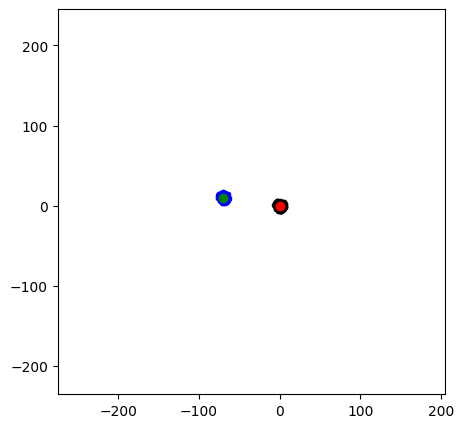

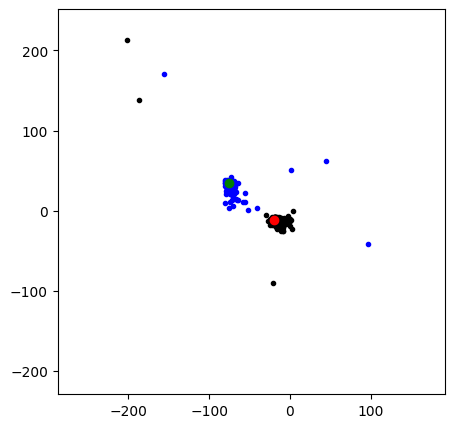

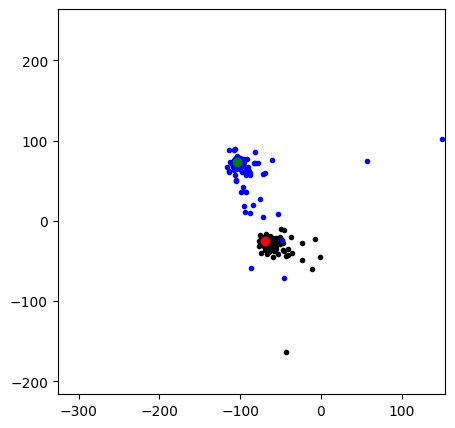

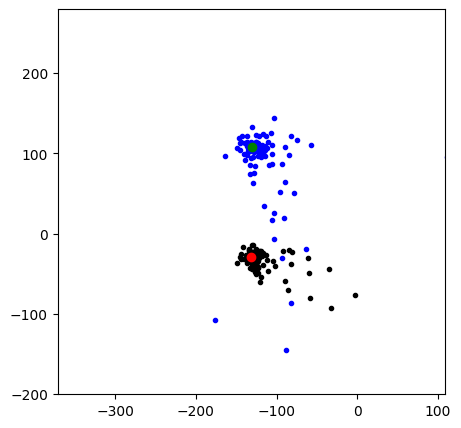

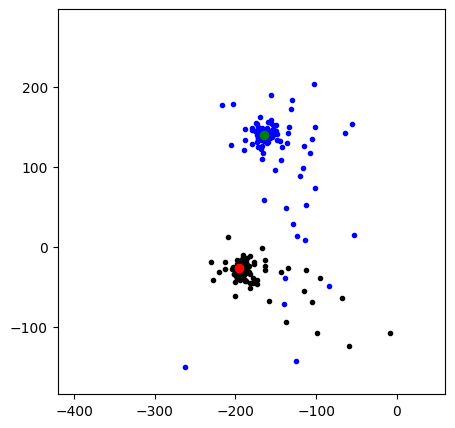

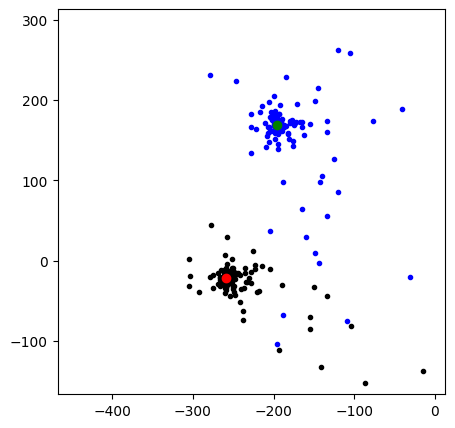

In [230]:
c = 6
b = 240

for i in range(c):
        
        j = int(i*n/c)
        plt.figure(figsize = (5,5))

        plt.scatter(stars1[j,:,0],stars1[j,:,1], marker = 'o', s = 9, color = 'black')
        plt.scatter(stars2[j,:,0],stars2[j,:,1], marker = 'o', s = 9, color = 'blue')
        plt.scatter(bary1[j,0], bary1[j,1], color = 'red', label = 'Perturber position')
        plt.scatter(bary2[j,0], bary2[j,1], color = 'green', label = 'Perturber position')

        #centre between the two barycentres
        centre = [(bary1[j,0]+bary2[j,0])/2, (bary1[j,1]+bary2[j,1])/2]
              
        plt.xlim(-b+centre[0],b+centre[0])
        plt.ylim(-b+centre[1],b+centre[1])

        # plt.xlim(-b,b)
        # plt.ylim(-b,b)

        plt.show()

A faster encounter between a small and much lighter galaxy that leads to tidal tails

In [217]:
p1 = 300       #number of stars
p2 = 300
r_max = 7    #radius of galaxy

initial =[-38,10]
mu = 7    #mass ratio of galaxy 1 to galaxy 2
V = 1.25

#find the initial coordinates, positions, masses and periods of the stars
x1,y1, v_x1, v_y1,x2,y2,v_x2,v_y2, m1,m2, e, v_p = initialise_values(p1,p2, initial, r_max, mu,V)

#Set the duration of the simulation to be double the time taken for galaxy 2 to reach its closest approach with the galaxy
T = 4*np.sqrt(initial[0]**2 + initial[1]**2)/v_p
print('Time scale of simulation is ', T)

n = 5000      #number of time steps
a = T/n
print('Time step is ',a)

Softening constant e =  0.404145188432738
Time scale of simulation is  19.207109794726186
Time step is  0.0038414219589452373


In [218]:
stars1, stars2, bary1, bary2 = all_stars(x1,y1,v_x1, v_y1, x2, y2, v_x2, v_y2, m1, m2, v_p,a, e, n, initial)

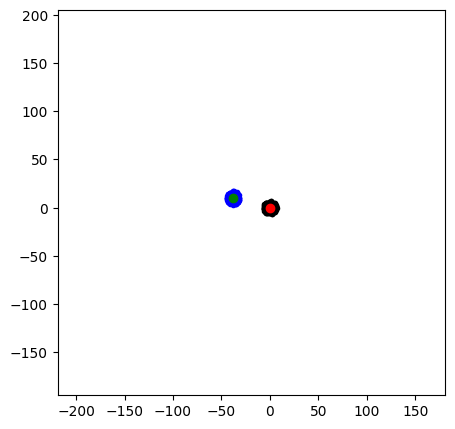

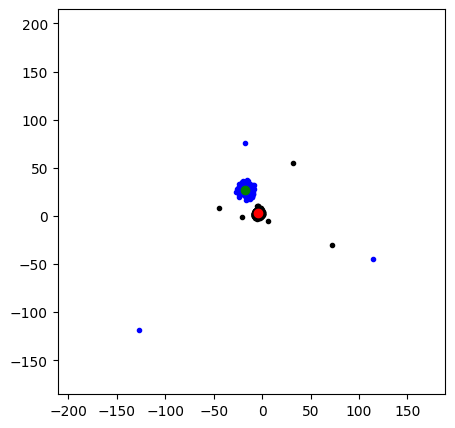

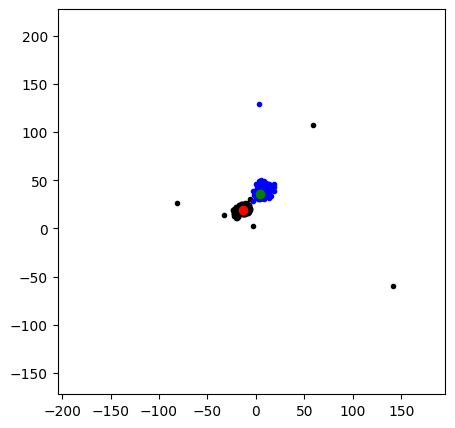

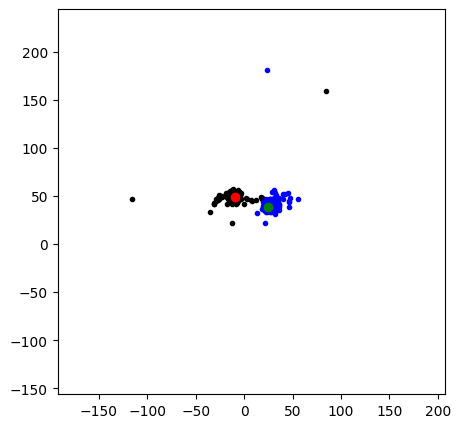

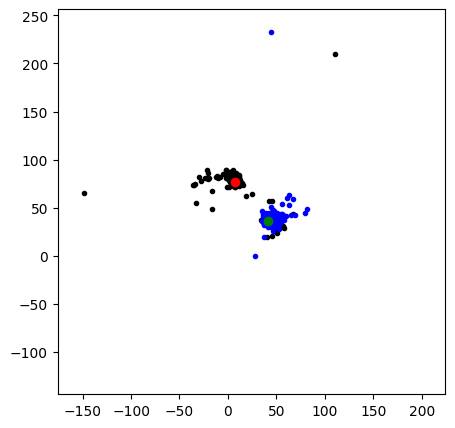

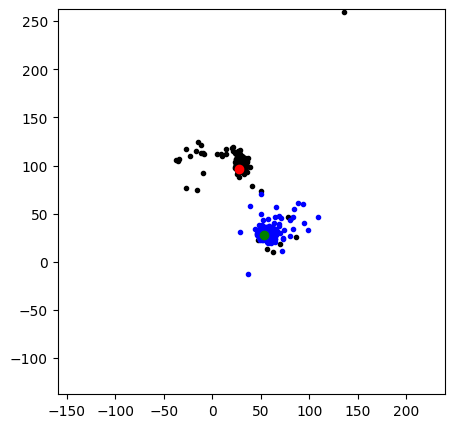

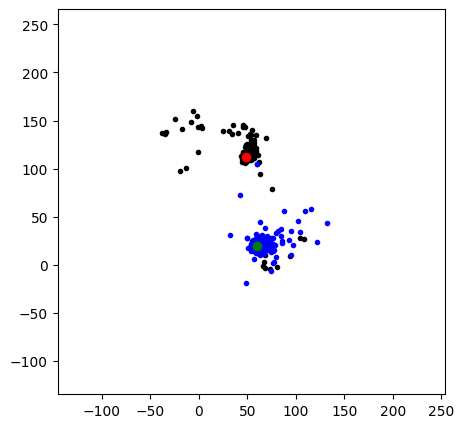

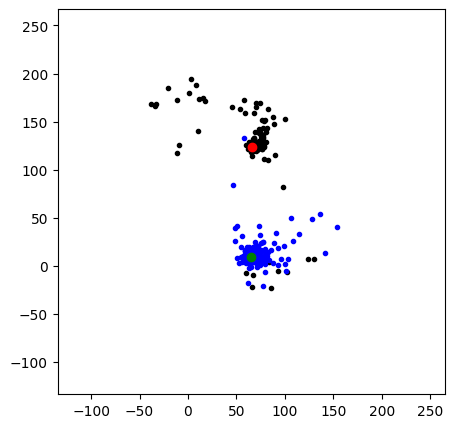

In [219]:
c = 8
b = 200

for i in range(c):
        
        j = int(i*n/c)
        plt.figure(figsize = (5,5))

        plt.scatter(stars1[j,:,0],stars1[j,:,1], marker = 'o', s = 9, color = 'black')
        plt.scatter(stars2[j,:,0],stars2[j,:,1], marker = 'o', s = 9, color = 'blue')
        plt.scatter(bary1[j,0], bary1[j,1], color = 'red', label = 'Perturber position')
        plt.scatter(bary2[j,0], bary2[j,1], color = 'green', label = 'Perturber position')

        #centre between the two barycentres
        centre = [(bary1[j,0]+bary2[j,0])/2, (bary1[j,1]+bary2[j,1])/2]
              
        plt.xlim(-b+centre[0],b+centre[0])
        plt.ylim(-b+centre[1],b+centre[1])

        plt.show()

A slow encounter that leads to a merger

In [232]:
p1 = 200       #number of stars
p2 = 200
r_max = 7    #radius of galaxy

initial =[-30,10]
mu = 1   #mass ratio of galaxy 1 to galaxy 2
V = 0.2

#find the initial coordinates, positions, masses and periods of the stars
x1,y1, v_x1, v_y1,x2,y2,v_x2,v_y2, m1,m2, e, v_p = initialise_values(p1,p2, initial, r_max, mu,V)

#Set the duration of the simulation to be double the time taken for galaxy 2 to reach its closest approach with the galaxy
T = 4*np.sqrt(initial[0]**2 + initial[1]**2)/v_p
print('Time scale of simulation is ', T)

n = 5000      #number of time steps
a = T/n
print('Time step is ',a)

Softening constant e =  0.49497474683058323
Time scale of simulation is  118.32159566199232
Time step is  0.023664319132398463


In [233]:
stars1, stars2, bary1, bary2 = all_stars(x1,y1,v_x1, v_y1, x2, y2, v_x2, v_y2, m1, m2, v_p,a, e, n, initial)

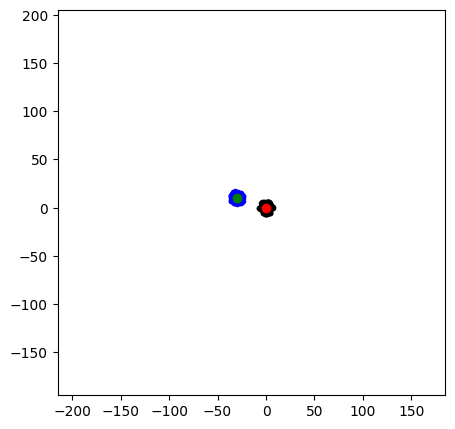

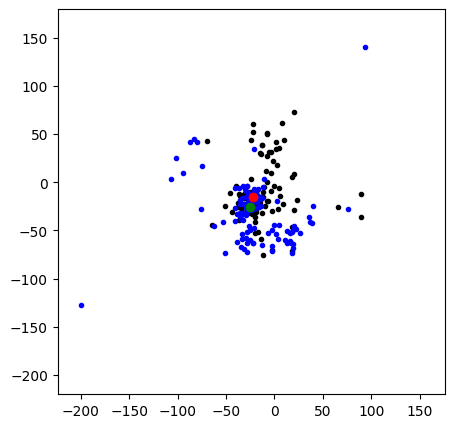

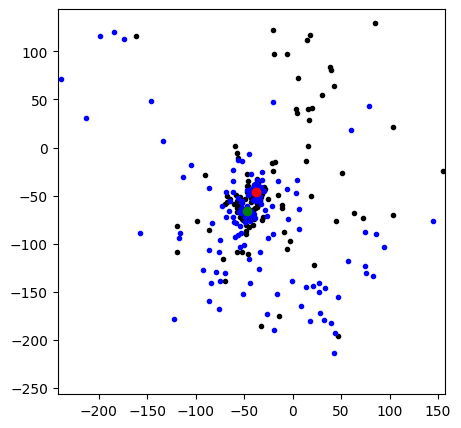

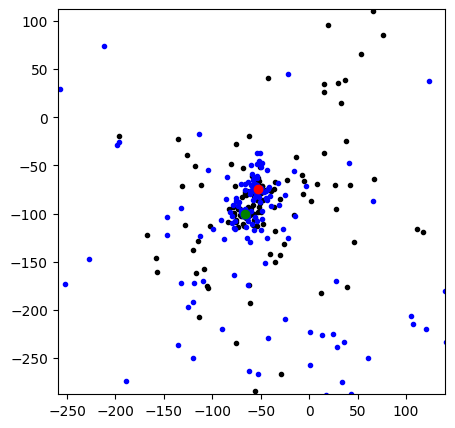

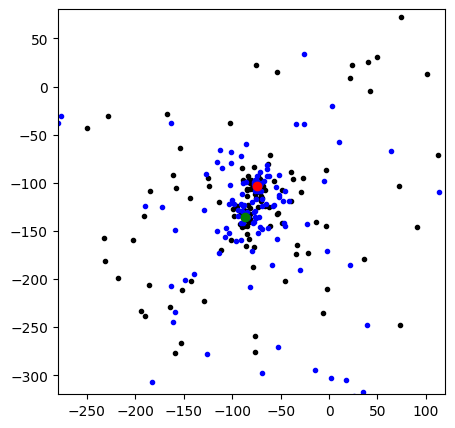

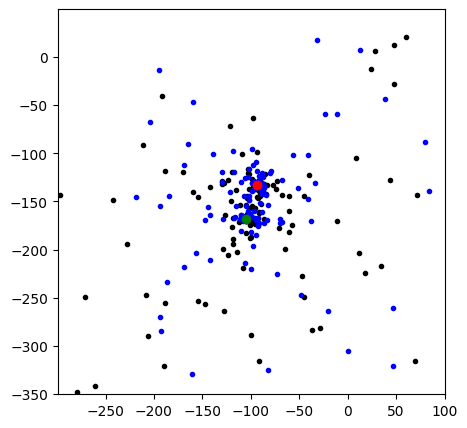

In [234]:
c = 6
b = 200

for i in range(c):
        
        j = int(i*n/c)
        plt.figure(figsize = (5,5))

        plt.scatter(stars1[j,:,0],stars1[j,:,1], marker = 'o', s = 9, color = 'black')
        plt.scatter(stars2[j,:,0],stars2[j,:,1], marker = 'o', s = 9, color = 'blue')
        plt.scatter(bary1[j,0], bary1[j,1], color = 'red', label = 'Perturber position')
        plt.scatter(bary2[j,0], bary2[j,1], color = 'green', label = 'Perturber position')

        #centre between the two barycentres
        centre = [(bary1[j,0]+bary2[j,0])/2, (bary1[j,1]+bary2[j,1])/2]
              
        plt.xlim(-b+centre[0],b+centre[0])
        plt.ylim(-b+centre[1],b+centre[1])

        # plt.xlim(-b,b)
        # plt.ylim(-b,b)

        plt.show()